In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import linregress

### change directory to import more scripts
sys.path.append(str(Path().resolve().parents[0]))

import generate_wind
from utils import tools

if os.getcwd().split(os.sep)[-1] == 'evaluation':
    os.chdir('..')

In [ ]:
config = tools.load_config("config.yaml")

noage_dir = os.path.join(config['data']['synth_dir'], 'ex_noise', 'wind_noage')
age_dir = os.path.join(config['data']['synth_dir'], 'ex_noise', 'wind_age')
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)
results_dir = 'results'

os.makedirs(results_dir, exist_ok=True)

features = config['features']

params = config['wind_params']

mapping = {'power_t1': 'Enercon E-70 E4 2.300',
           'power_t2': 'Enercon E-82 E2 2.000',
           'power_t3': 'Enercon E-115 2.500',
           'power_t4': 'Vestas V90',
           'power_t5': 'Vestas V112-3.45',
           'power_t6': 'Vestas V80-1.8'
           }

FileNotFoundError: [Errno 2] No such file or directory: 'config.yaml'

In [4]:
files = os.listdir(age_dir)
station_files_synthetic = [f for f in files if 'parameter' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')
turbine_params = pd.read_csv(os.path.join(age_dir, 'turbine_parameter.csv'), sep=';')
wind_params = pd.read_csv(os.path.join(age_dir, 'wind_parameter.csv'), sep=';', dtype={"park_id": str})

raw_power_curves, cp_curves, specs = generate_wind.get_turbines(turbine_path=turbine_path,
                                                        cp_path=cp_path,
                                                        specs_path=specs_path,
                                                        params=params)
power_curves = pd.DataFrame()
for turbine in raw_power_curves.columns:
    power_curve = generate_wind.interpolate(power_curve=raw_power_curves[turbine],
                                            cut_out=specs[turbine]['cut_out'])
    power_curves[turbine] = power_curve
power_curves /= 1000 # convert to kW

FileNotFoundError: [Errno 2] No such file or directory: 'data/synthetic/ex_noise/wind_age'

In [45]:
def get_dataframes(path: str, file_list: list) -> list:
    list_of_dfs = {}
    for st in file_list:
        station_id = st.split('.')[0][-5:]
        station = pd.read_csv(os.path.join(path, st), sep=';')
        station['timestamp'] = pd.to_datetime(station['timestamp'], utc=True)
        station.set_index('timestamp', inplace=True)
        #station = station['2024-01-01':'2024-12-31']
        power_park = np.zeros(len(station))
        for key, _ in mapping.items():
            station[key] /= 1e6 # convert to MW
            power_park += station[key]
        #metadata = pd.read_csv(os.path.join(path, md))
        station['power_park'] = power_park
        list_of_dfs[station_id] = station
    return list_of_dfs

In [46]:
df_age = get_dataframes(age_dir, station_files_synthetic)
df_noage = get_dataframes(noage_dir, station_files_synthetic)

In [55]:
results = defaultdict(list)
max_load =  2.5 # 2.3 + 2.0 + 2.5 + 2.0 + 3.45 + 1.8
turbine_id = 't3'
for key in df_age.keys():
    commissioning_date = wind_params[wind_params.park_id == key]['commissioning_date'].iloc[0]
    age = (df_age[key].index - pd.to_datetime(commissioning_date, utc=True)).days / 365
    #results['station_id'].append(key)
    #results['commissioning_date'].append(commissioning_date)
    #results['age'].append(age)
    power_park_age = df_age[key][f'power_{turbine_id}']
    power_park_noage = df_noage[key][f'power_{turbine_id}']
    load_factor_age = power_park_age / max_load
    load_factor_noage = power_park_noage / max_load
    mean_load_factor_noage = load_factor_noage.mean()
    wclf = load_factor_age * (mean_load_factor_noage / load_factor_noage) * 100 # weather corrected load factor
    results['wclf'].extend(wclf)
    results['power_age'].extend(power_park_age)
    results['power_noage'].extend(power_park_noage)
    results['key'].extend([key for i in range(len(df_age[key]))])
    results['load_factor_age'].extend(load_factor_age)
    results['load_factor_noage'].extend(load_factor_noage)
    results['age'].extend(age)
    results['timestamp'].extend(df_age[key].index)
    #avg_load_factor_age = load_factor_age.mean()
    #avg_load_factor_noage = load_factor_noage.mean()
    # results['power_sum_age'].append(power_park_age.sum() / 1e3 / max_load) # GWh
    # results['power_sum_noage'].append(power_park_noage.sum() / 1e3 / max_load)
    # results['avg_load_factor_age'].append(avg_load_factor_age)
    # results['avg_load_factor_noage'].append(avg_load_factor_noage)
results = pd.DataFrame(results)

In [56]:
results['timestamp'] = pd.to_datetime(results['timestamp'])

results['year'] = results['timestamp'].dt.to_period('Y')  # z. B. 2024-01, 2024-02

results_avg = results.groupby(['year', 'key']).agg({
    'load_factor_age': 'mean',
    'load_factor_noage': 'mean',
    'wclf': 'mean',
    'age': 'max',
    'power_age': 'sum',
    'power_noage': 'sum'
}).reset_index()

/var/folders/pz/kvbp4_tx4gj8hj2xjrqppmvr0000gn/T/ipykernel_49433/3269262181.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  results['year'] = results['timestamp'].dt.to_period('Y')  # z. B. 2024-01, 2024-02


In [57]:
# Calculate AEP

def calc_annual_aep(df, power_col="power"):
    return df.groupby(["age", 'key'])[power_col].sum()  # MW → GWh

aep_ref = calc_annual_aep(results_avg, 'power_noage')
aep_aged = calc_annual_aep(results_avg, 'power_age')

# AEP-Reduktionsrate berechnen
aep_reduction = ((aep_aged - aep_ref) / aep_ref * 100).reset_index()
aep_reduction.rename(columns={0: 'aep'}, inplace=True)
aep_reduction['age_year'] = np.floor(aep_reduction['age']).astype(int)

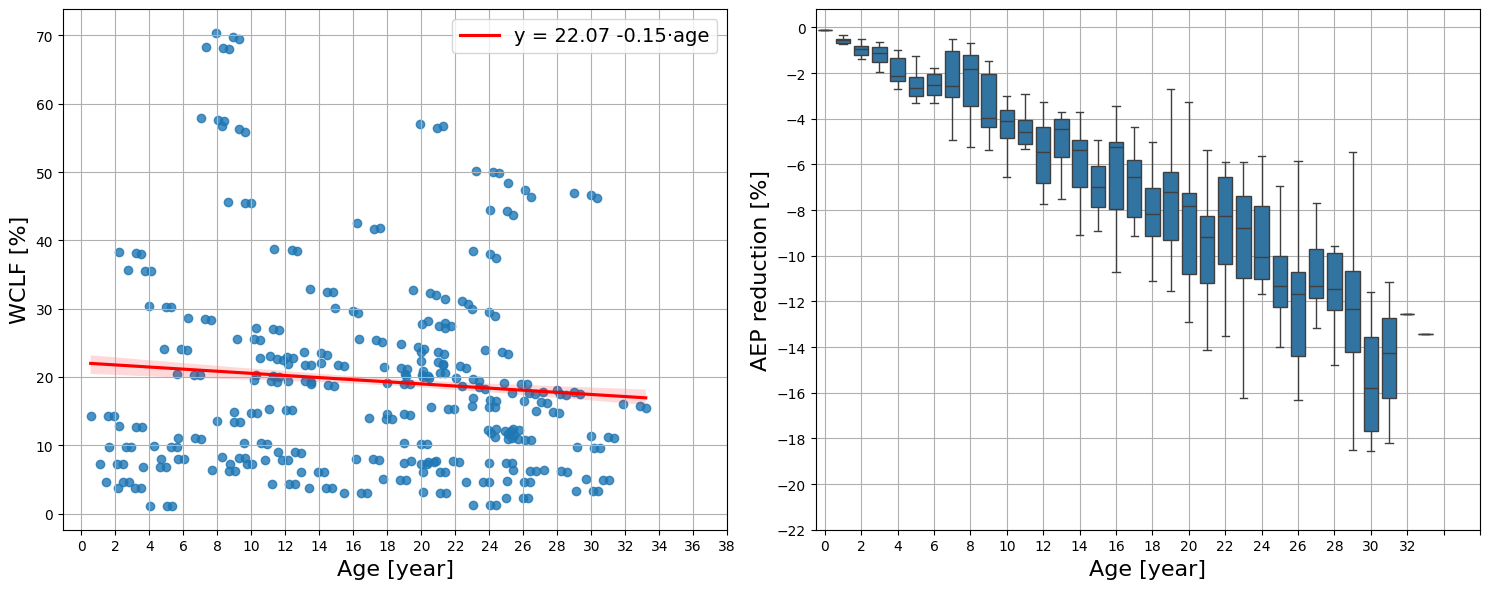

In [58]:
results_avg.dropna(inplace=True)

fontsize = 16

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

slope_rel, intercept_rel, _, _, _ = linregress(results_avg['age'], results_avg['wclf'])

# Formatierte Regressionsformeln
label_rel = f'y = {intercept_rel:.2f} {slope_rel:.2f}·age'

sns.regplot(data=results_avg, x='age', y='wclf', ax=axes[0],
            scatter=True, ci=50, line_kws={'label': label_rel, 'color': 'red'})
sns.boxplot(data=aep_reduction, x='age_year', y='aep', orient='x', showfliers=False, ax=axes[1])

axes[0].set_xlabel('Age [year]', fontsize=fontsize)
axes[0].set_ylabel('WCLF [%]', fontsize=fontsize)
axes[0].set_xticks(np.arange(0,40,2))
#axes[0].set_yticks(np.arange(-26,2,2))
axes[0].grid(True)
axes[1].set_xlabel('Age [year]', fontsize=fontsize)
axes[1].set_xticks(np.arange(0,38,2))
axes[1].set_yticks(np.arange(-22,2,2))
axes[1].set_ylabel('AEP reduction [%]', fontsize=fontsize)
axes[1].grid(True)

axes[0].legend(fontsize=fontsize - 2)
#axes[1].legend(fontsize=fontsize - 2)

plt.tight_layout()
plt.show()